In [1]:
import pandas as pd
df = pd.read_csv('housing.csv')

In [2]:
df['rooms_per_household'] = df['total_rooms']/df['households']
df['bedrooms_per_room'] = df['total_bedrooms']/df['total_rooms']
df['population_per_household'] = df['population']/df['households']

df.drop(columns=['total_rooms', 'total_bedrooms', 'population', 'households'], inplace=True)

In [3]:
df.dropna(inplace=True)

In [4]:
ocn = df['ocean_proximity']  # Save it first
df = df.drop(columns=['ocean_proximity'])  # Then drop it


In [5]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Define IQR-based caps
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap values (replace extreme values with the nearest non-outlier)
houses_clean = df.clip(lower_bound, upper_bound, axis=1)
outliers_clean = ((houses_clean < (Q1 - 1.5 * IQR)) | (houses_clean > (Q3 + 1.5 * IQR)))
print(outliers_clean.sum())  # Now should be 0


longitude                   0
latitude                    0
housing_median_age          0
median_income               0
median_house_value          0
rooms_per_household         0
bedrooms_per_room           0
population_per_household    0
dtype: int64


In [6]:
ocean_dummies = pd.get_dummies(ocn, prefix='ocean', drop_first=True, dtype='int')

# Step 4: Concatenate encoded columns with original DataFrame
df = pd.concat([df, ocean_dummies], axis=1)

In [10]:
print(df.dtypes)


longitude                   float64
latitude                    float64
housing_median_age          float64
median_income               float64
median_house_value          float64
rooms_per_household         float64
bedrooms_per_room           float64
population_per_household    float64
ocean_INLAND                  int64
ocean_ISLAND                  int64
ocean_NEAR BAY                int64
ocean_NEAR OCEAN              int64
dtype: object


In [11]:
from scipy import stats

z_scores = stats.zscore(df.select_dtypes(include='number'))
outliers = (abs(z_scores) > 3).sum()
print("Outliers per column:\n", outliers)


Outliers per column:
 765


In [12]:
import numpy as np

# Keep only rows where all z-scores are < 3
df_no_outliers = df[(np.abs(z_scores) < 3).all(axis=1)]
print("After removing outliers:", df_no_outliers.shape)


After removing outliers: (19672, 12)


In [13]:
from scipy import stats

z_scores = stats.zscore(df.select_dtypes(include='number'))
outliers = (abs(z_scores) > 3).sum()
print("Outliers per column:\n", outliers)

Outliers per column:
 765


In [14]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Define IQR-based caps
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap values (replace extreme values with the nearest non-outlier)
houses_clean = df.clip(lower_bound, upper_bound, axis=1)
outliers_clean = ((houses_clean < (Q1 - 1.5 * IQR)) | (houses_clean > (Q3 + 1.5 * IQR)))
print(outliers_clean.sum())  # Now should be 0


longitude                   0
latitude                    0
housing_median_age          0
median_income               0
median_house_value          0
rooms_per_household         0
bedrooms_per_room           0
population_per_household    0
ocean_INLAND                0
ocean_ISLAND                0
ocean_NEAR BAY              0
ocean_NEAR OCEAN            0
dtype: int64


In [16]:
pip install matplotlib

  Using cached matplotlib-3.10.3-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.58.4-cp313-cp313-win_amd64.whl.metadata (108 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-win_amd64.whl.metadata (6.3 kB)
  Using cached pillow-11.2.1-cp313-cp313-win_amd64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.2-cp313-cp313-win_amd64.whl (223 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.58.4-cp313-cp313-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.8-cp313-cp313-win_amd64.whl (71 kB)
Using cached pillow-11.2.1-cp313-cp313-win_amd64.whl (2.7 MB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)

   ---------------------------------------- 0/7 [pyparsing]
   -

In [18]:
# Remove outliers completely (strict cleaning)
df_clean = df[
    (df['longitude'].between(-125, -114)) &
    (df['median_income'] > 0) &
    (df['bedrooms_per_room'].between(0.1, 0.6)) &
    (df['population_per_household'] < 10)
].copy()

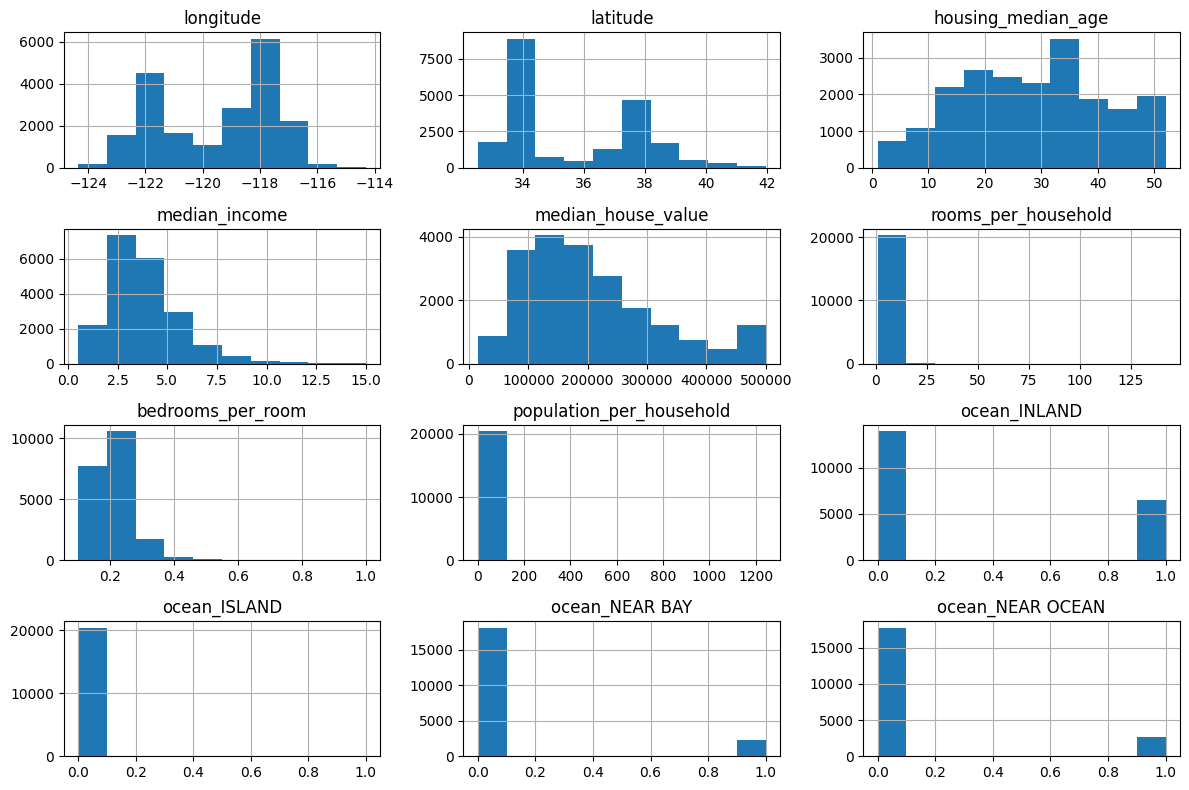

In [19]:
import matplotlib.pyplot as plt
df.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()


In [30]:
df.rename(columns={'ocean_NEAR BAY': 'ocean_nearbay', 
                   'ocean_NEAR OCEAN': 'ocean_nearocean',}, inplace=True)

In [31]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'median_income',
       'median_house_value', 'rooms_per_household', 'bedrooms_per_room',
       'population_per_household', 'ocean_INLAND', 'ocean_ISLAND',
       'ocean_nearbay', 'ocean_nearocean'],
      dtype='object')

In [32]:
# 1. Fix latitude range (California coordinates)
df = df[df['latitude'].between(32, 42)]

# 2. Handle rooms_per_household outliers
rooms_q95 = df['rooms_per_household'].quantile(0.95)
df = df[df['rooms_per_household'] <= rooms_q95]

# 3. Verify house value units
if df['median_house_value'].max() > 1_000_000:  # If values seem too high
    df['median_house_value'] = df['median_house_value'] / 1000  # Convert from $ to $1000s

# 4. Final sanity checks - CORRECTED VERSION
df = df[
    (df['housing_median_age'] > 0) &
    (df['ocean_INLAND'].isin([0, 1])) &  # Ensure binary values
    (df['ocean_nearocean'].isin([0, 1])) &  # Fixed underscore naming
    (df['ocean_nearbay'].isin([0, 1])) &  # Fixed underscore naming
    (df['ocean_ISLAND'].isin([0, 1]))  # No trailing &
]

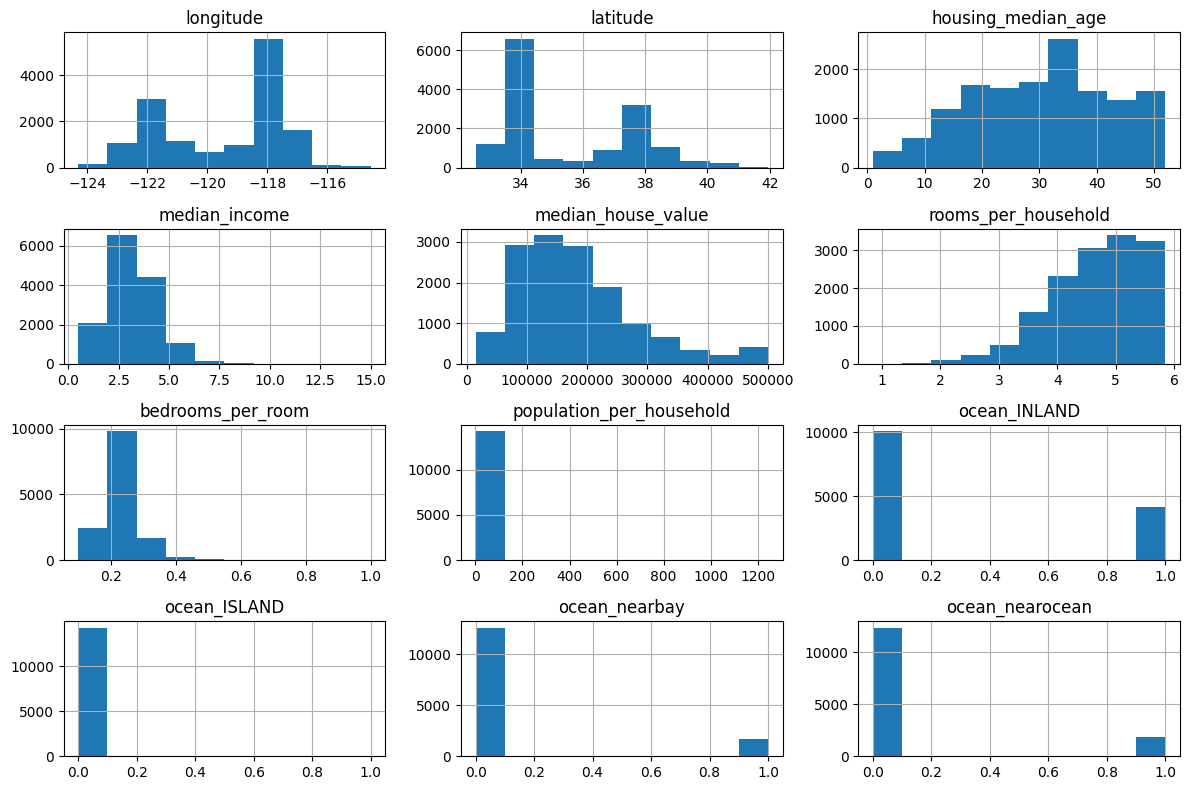

In [33]:
import matplotlib.pyplot as plt
df.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()


In [34]:
df.to_csv('cleaned_housing22.csv', index=False)

In [35]:
x = df.drop(columns=['median_house_value'])
y = df['median_house_value']    

In [36]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso  
feature_sel = SelectFromModel(Lasso(alpha=0.005, random_state=0))
feature_sel.fit(x, y)

,estimator,Lasso(alpha=0...andom_state=0)
,threshold,None
,prefit,False
,norm_order,1
,max_features,None
,importance_getter,'auto'
,alpha,0.005
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000


In [37]:
feature_sel.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

Data into 80-20

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y,      
                                                    test_size=0.2, 
                                                    random_state=42)
from sklearn.linear_model import LinearRegression
lr = LinearRegression() 
lr.fit(x_train, y_train)
from sklearn.metrics import mean_squared_error, r2_score
y_test_pred = lr.predict(x_test)
y_train_pred = lr.predict(x_train)




In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
lr_train_mse = mean_squared_error(y_train, y_train_pred)
lr_test_mse = mean_squared_error(y_test, y_test_pred)
lr_train_r2 = r2_score(y_train, y_train_pred)
lr_test_r2 = r2_score(y_test, y_test_pred)

In [42]:
lr_results = pd.DataFrame({
    'Metric': ['Train MSE', 'Test MSE', 'Train R2', 'Test R2'],
    'Value': [lr_train_mse, lr_test_mse, lr_train_r2, lr_test_r2]
}).transpose()
lr_results

,0,1,2,3
Metric,Train MSE,Test MSE,Train R2,Test R2
Value,4896856104.032906,5145601867.284605,0.504996,0.491097


In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [100, 150],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt']
}

grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid.fit(x_train, y_train)
rf_train_pred = grid.predict(x_train)
rf_test_pred = grid.predict(x_test)

In [69]:
from sklearn.metrics import mean_squared_error, r2_score
rf_train_mse = mean_squared_error(y_train, rf_train_pred)
rf_test_mse = mean_squared_error(y_test, rf_test_pred)
rf_train_r2 = r2_score(y_train, rf_train_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)

rf_results = pd.DataFrame({
    'Metric': ['Train MSE', 'Test MSE', 'Train R2', 'Test R2'],
    'Value': [rf_train_mse, rf_test_mse, rf_train_r2, rf_test_r2]
}).transpose()
rf_results

,0,1,2,3
Metric,Train MSE,Test MSE,Train R2,Test R2
Value,711025064.231101,2416694907.808939,0.928125,0.760987


In [70]:
import numpy as np

# Input features (must be 2D array)
input_sample = np.array([[-122.28,37.84,52.0,1.6875,4.703225806451613,0.2194787379972565,2.5483870967741935,0,0,1,0]])  # Shape: (1, 6)

# Predict
prediction = grid.predict(input_sample)  # Replace 'model' with your trained model
print(f"Predicted house value: ${prediction[0]:,.2f}")

Predicted house value: $128,484.33


c:\Users\Adnan\Desktop\Traing models\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [ ]:
,132000.0

<>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
C:\Users\Adnan\AppData\Local\Temp\ipykernel_22664\1667726174.py:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
  108900.0("")


TypeError: 'float' object is not callable

In [72]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


<Axes: >

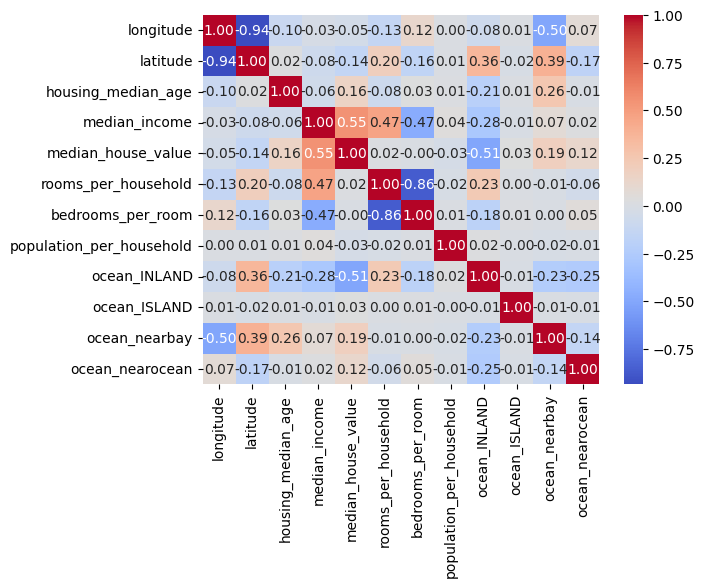

In [73]:
correlation = df.corr()
import seaborn as sns
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')

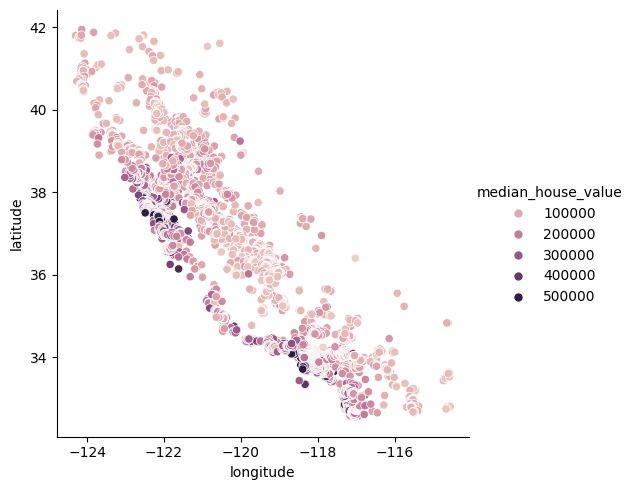

In [77]:
import seaborn as sns
sns.relplot(x='longitude', y='latitude', data=df, hue='median_house_value')

In [80]:
df.outliers = df[(df['longitude'] < -125) | (df['longitude'] > -114) |
                 (df['median_income'] <= 0) | 
                    (df['bedrooms_per_room'] < 0.1) |
                    (df['population_per_household'] < 0) |
                    (df['rooms_per_household'] < 0.1) |
                    (df['ocean_nearbay'] == 1) |
                    (df['ocean_nearocean'] == 1) |
                    (df['ocean_INLAND'] == 1) |
                    (df['ocean_ISLAND'] == 1)]


C:\Users\Adnan\AppData\Local\Temp\ipykernel_22664\2422815177.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.outliers = df[(df['longitude'] < -125) | (df['longitude'] > -114) |


In [84]:
from sklearn.ensemble import RandomForestRegressor
rf2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf2.fit(x_train, y_train)
rf2_train_pred = rf2.predict(x_train)
rf2_test_pred = rf2.predict(x_test)
from sklearn.metrics import mean_squared_error, r2_score
rf2_train_mse = mean_squared_error(y_train, rf2_train_pred)
rf2_test_mse = mean_squared_error(y_test, rf2_test_pred)
rf2_train_r2 = r2_score(y_train, rf2_train_pred)
rf2_test_r2 = r2_score(y_test, rf2_test_pred)
rf2_results = pd.DataFrame({
    'Metric': ['Train MSE', 'Test MSE', 'Train R2', 'Test R2'],
    'Value': [rf2_train_mse, rf2_test_mse, rf2_train_r2, rf2_test_r2]
}).transpose()
rf2_results


,0,1,2,3
Metric,Train MSE,Test MSE,Train R2,Test R2
Value,302653811.37577,2449098768.815031,0.969406,0.757783


In [86]:
import numpy as np

# Input features (must be 2D array)
input_sample = np.array([[-120.87,38.37,28.0,2.8125,5.7277936962750715,0.1913456728364182,2.312320916905444,1,0,0,0]])  # Shape: (1, 6)

# Predict
prediction = grid.predict(input_sample)  # Replace 'model' with your trained model
print(f"Predicted house value: ${prediction[0]:,.2f}")

Predicted house value: $117,384.72


c:\Users\Adnan\Desktop\Traing models\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [87]:
df.to_csv('cleaned_housing.csv', index=False)